In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import importlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import csbdeep


from csbdeep.utils import _raise, Path, axes_check_and_normalize,axes_dict, move_image_axes, move_channel_for_backend, backend_channels_last
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import matplotlib.pyplot as plt
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
import matplotlib.pyplot as plt
import os
import sys
import random
import warnings
from csbdeep.utils import Path, normalize
import numpy as np
import pandas as pd
from externalmodels.unet import *
from csbdeep.io import load_training_data
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from csbdeep.utils import axes_dict, plot_some, plot_history
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.objectives import categorical_crossentropy
import tensorflow as tf

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imageri

In [2]:
(X,Y),(X_val, Y_val), axes = load_training_data('/data/u934/service_imagerie/v_kapoor/StarDistTraining/UnetSegmentation.npz',validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
IMG_HEIGHT = X.shape[1]
IMG_WIDTH = X.shape[2]
IMG_CHANNELS = X.shape[c]
print(IMG_HEIGHT , IMG_WIDTH, IMG_CHANNELS )
print(X_val.shape)


number of training images:	 40230
number of validation images:	 4470
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1
64 64 1
(4470, 64, 64, 1)


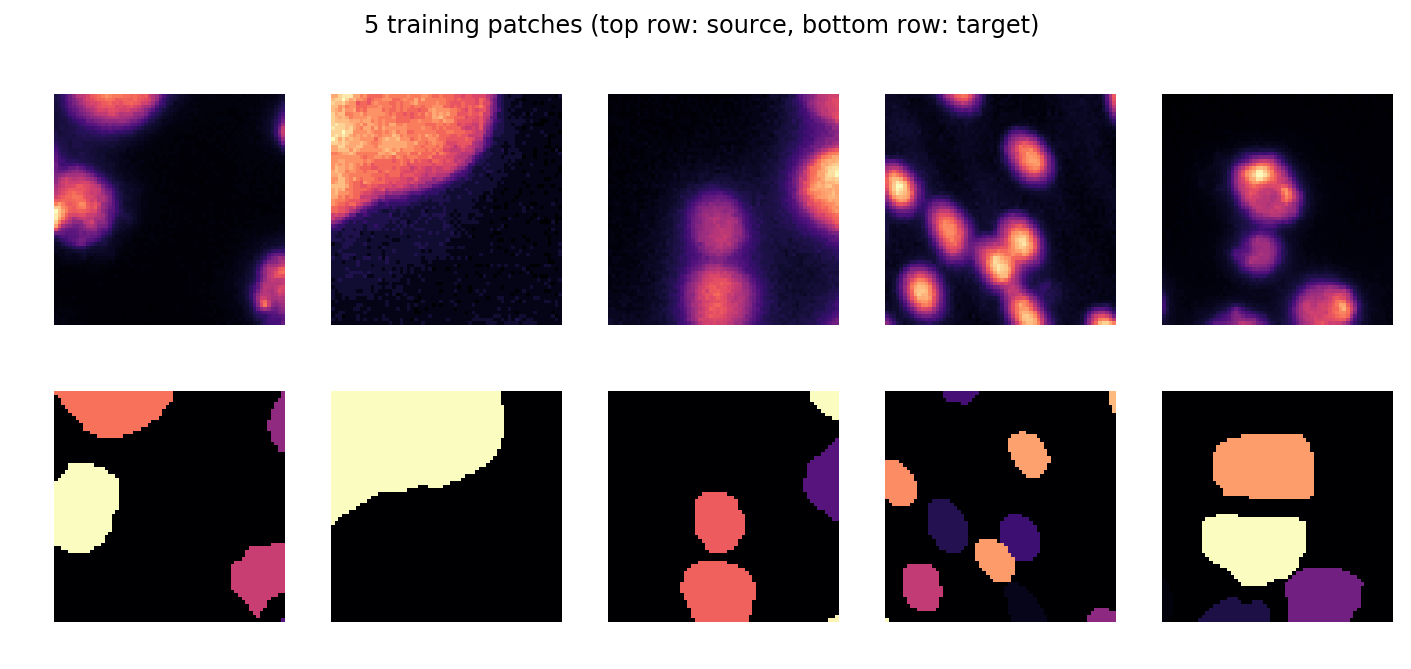

In [3]:
plt.figure(figsize=(12,5))
plot_some(X[:5],Y[:5])

plt.suptitle('5 training patches (top row: source, bottom row: target)');

In [4]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=150,train_epochs = 400, train_learning_rate = 0.0002, unet_residual = True)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=400, train_learning_rate=0.0002, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=150, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'train_batch_size': 16,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 400,
 'train_learning_rate': 0.0002,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 150,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 5,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': True}

In [5]:
model = CARE(config, 'CAREResUNet_model', basedir='models')

In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/400
150/150 [==============================] - 19s 129ms/step - loss: 0.0737 - mse: 0.0291 - mae: 0.0737 - val_loss: 0.0710 - val_mse: 0.0310 - val_mae: 0.0710
Epoch 2/400
150/150 [==============================] - 17s 116ms/step - loss: 0.0673 - mse: 0.0288 - mae: 0.0673 - val_loss: 0.0658 - val_mse: 0.0269 - val_mae: 0.0658
Epoch 3/400
150/150 [==============================] - 17s 115ms/step - loss: 0.0648 - mse: 0.0265 - mae: 0.0648 - val_loss: 0.0646 - val_mse: 0.0277 - val_mae: 0.0646
Epoch 4/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0626 - mse: 0.0255 - mae: 0.0626 - val_loss: 0.0598 - val_mse: 0.0240 - val_mae: 0.0598
Epoch 5/400
150/150 [==============================] - 17s 116ms/step - loss: 0.0605 - mse: 0.0247 - mae: 0.0605 - val_loss: 0.0593 - val_mse: 0.0233 - val_mae: 0.0593
Epoch 6/400
150/150 [==============================] - 17s 116ms/step - loss: 0.0600 - mse: 0.0241 - mae: 0.0600 - val_loss: 0.0605 - val_mse: 0.0240 - val_mae:

150/150 [==============================] - 18s 118ms/step - loss: 0.0540 - mse: 0.0211 - mae: 0.0540 - val_loss: 0.0539 - val_mse: 0.0216 - val_mae: 0.0539
Epoch 50/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0547 - mse: 0.0219 - mae: 0.0547 - val_loss: 0.0544 - val_mse: 0.0212 - val_mae: 0.0544
Epoch 51/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0530 - mse: 0.0209 - mae: 0.0530 - val_loss: 0.0534 - val_mse: 0.0210 - val_mae: 0.0534
Epoch 52/400
150/150 [==============================] - 18s 118ms/step - loss: 0.0536 - mse: 0.0209 - mae: 0.0536 - val_loss: 0.0544 - val_mse: 0.0216 - val_mae: 0.0544
Epoch 53/400
150/150 [==============================] - 18s 118ms/step - loss: 0.0533 - mse: 0.0208 - mae: 0.0533 - val_loss: 0.0543 - val_mse: 0.0204 - val_mae: 0.0543
Epoch 54/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0530 - mse: 0.0204 - mae: 0.0530 - val_loss: 0.0534 - val_mse: 0.0209 - val_mae: 0.0534

150/150 [==============================] - 18s 117ms/step - loss: 0.0467 - mse: 0.0174 - mae: 0.0467 - val_loss: 0.0482 - val_mse: 0.0187 - val_mae: 0.0482
Epoch 98/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0461 - mse: 0.0175 - mae: 0.0461 - val_loss: 0.0475 - val_mse: 0.0179 - val_mae: 0.0475
Epoch 99/400
150/150 [==============================] - 18s 118ms/step - loss: 0.0457 - mse: 0.0173 - mae: 0.0457 - val_loss: 0.0473 - val_mse: 0.0177 - val_mae: 0.0473
Epoch 100/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0470 - mse: 0.0178 - mae: 0.0470 - val_loss: 0.0476 - val_mse: 0.0183 - val_mae: 0.0476
Epoch 101/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0455 - mse: 0.0173 - mae: 0.0455 - val_loss: 0.0473 - val_mse: 0.0180 - val_mae: 0.0473
Epoch 102/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0437 - mse: 0.0163 - mae: 0.0437 - val_loss: 0.0472 - val_mse: 0.0181 - val_mae: 0.0

150/150 [==============================] - 18s 117ms/step - loss: 0.0379 - mse: 0.0138 - mae: 0.0379 - val_loss: 0.0424 - val_mse: 0.0163 - val_mae: 0.0424
Epoch 146/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0386 - mse: 0.0139 - mae: 0.0386 - val_loss: 0.0435 - val_mse: 0.0167 - val_mae: 0.0435
Epoch 147/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0388 - mse: 0.0140 - mae: 0.0388 - val_loss: 0.0425 - val_mse: 0.0158 - val_mae: 0.0425
Epoch 148/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0390 - mse: 0.0141 - mae: 0.0390 - val_loss: 0.0432 - val_mse: 0.0160 - val_mae: 0.0432
Epoch 149/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0366 - mse: 0.0132 - mae: 0.0366 - val_loss: 0.0423 - val_mse: 0.0159 - val_mae: 0.0423
Epoch 150/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0374 - mse: 0.0136 - mae: 0.0374 - val_loss: 0.0431 - val_mse: 0.0156 - val_mae: 0

150/150 [==============================] - 18s 117ms/step - loss: 0.0327 - mse: 0.0114 - mae: 0.0327 - val_loss: 0.0394 - val_mse: 0.0146 - val_mae: 0.0394
Epoch 194/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0328 - mse: 0.0115 - mae: 0.0328 - val_loss: 0.0399 - val_mse: 0.0150 - val_mae: 0.0399
Epoch 195/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0334 - mse: 0.0116 - mae: 0.0334 - val_loss: 0.0396 - val_mse: 0.0148 - val_mae: 0.0396
Epoch 196/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0325 - mse: 0.0112 - mae: 0.0325 - val_loss: 0.0391 - val_mse: 0.0146 - val_mae: 0.0391
Epoch 197/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0326 - mse: 0.0113 - mae: 0.0326 - val_loss: 0.0394 - val_mse: 0.0145 - val_mae: 0.0394
Epoch 198/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0338 - mse: 0.0120 - mae: 0.0338 - val_loss: 0.0395 - val_mse: 0.0144 - val_mae: 0

150/150 [==============================] - 18s 117ms/step - loss: 0.0253 - mse: 0.0090 - mae: 0.0253 - val_loss: 0.0362 - val_mse: 0.0134 - val_mae: 0.0362
Epoch 241/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0257 - mse: 0.0089 - mae: 0.0257 - val_loss: 0.0362 - val_mse: 0.0135 - val_mae: 0.0362
Epoch 242/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0267 - mse: 0.0095 - mae: 0.0267 - val_loss: 0.0361 - val_mse: 0.0135 - val_mae: 0.0361
Epoch 243/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0260 - mse: 0.0092 - mae: 0.0260 - val_loss: 0.0361 - val_mse: 0.0136 - val_mae: 0.0361
Epoch 244/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0258 - mse: 0.0090 - mae: 0.0258 - val_loss: 0.0360 - val_mse: 0.0135 - val_mae: 0.0360
Epoch 245/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0258 - mse: 0.0091 - mae: 0.0258 - val_loss: 0.0360 - val_mse: 0.0135 - val_mae: 0

Epoch 287/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0240 - mse: 0.0086 - mae: 0.0240 - val_loss: 0.0355 - val_mse: 0.0134 - val_mae: 0.0355
Epoch 288/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0233 - mse: 0.0083 - mae: 0.0233 - val_loss: 0.0355 - val_mse: 0.0134 - val_mae: 0.0355
Epoch 289/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0242 - mse: 0.0085 - mae: 0.0242 - val_loss: 0.0355 - val_mse: 0.0134 - val_mae: 0.0355
Epoch 290/400
150/150 [==============================] - 18s 118ms/step - loss: 0.0240 - mse: 0.0085 - mae: 0.0240 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 291/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0239 - mse: 0.0085 - mae: 0.0239 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355

Epoch 00291: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 292/400
150/150 [==============================] - 18s 117ms/ste

Epoch 333/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0236 - mse: 0.0084 - mae: 0.0236 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 334/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0237 - mse: 0.0084 - mae: 0.0237 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 335/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0247 - mse: 0.0090 - mae: 0.0247 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 336/400
150/150 [==============================] - 17s 116ms/step - loss: 0.0226 - mse: 0.0082 - mae: 0.0226 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 337/400
150/150 [==============================] - 17s 117ms/step - loss: 0.0238 - mse: 0.0085 - mae: 0.0238 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 338/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0235 - mse: 0.0083 - mae: 0.0235 - val_loss: 0.0355 - val_mse: 0.013

150/150 [==============================] - 18s 117ms/step - loss: 0.0237 - mse: 0.0085 - mae: 0.0237 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 380/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0241 - mse: 0.0087 - mae: 0.0241 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 381/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0236 - mse: 0.0084 - mae: 0.0236 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355

Epoch 00381: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 382/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0238 - mse: 0.0085 - mae: 0.0238 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 383/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0235 - mse: 0.0084 - mae: 0.0235 - val_loss: 0.0355 - val_mse: 0.0133 - val_mae: 0.0355
Epoch 384/400
150/150 [==============================] - 18s 117ms/step - loss: 0.0

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


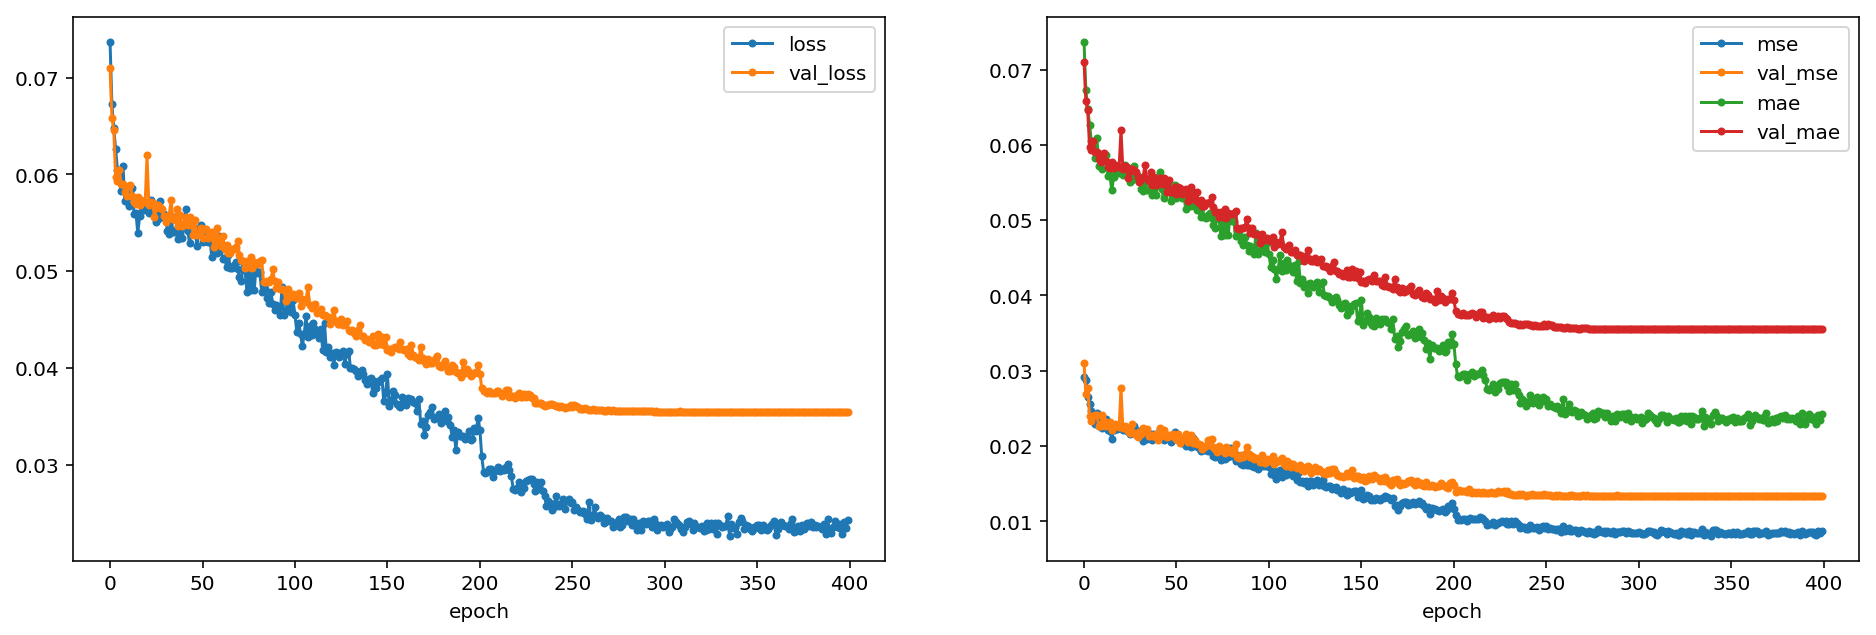

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

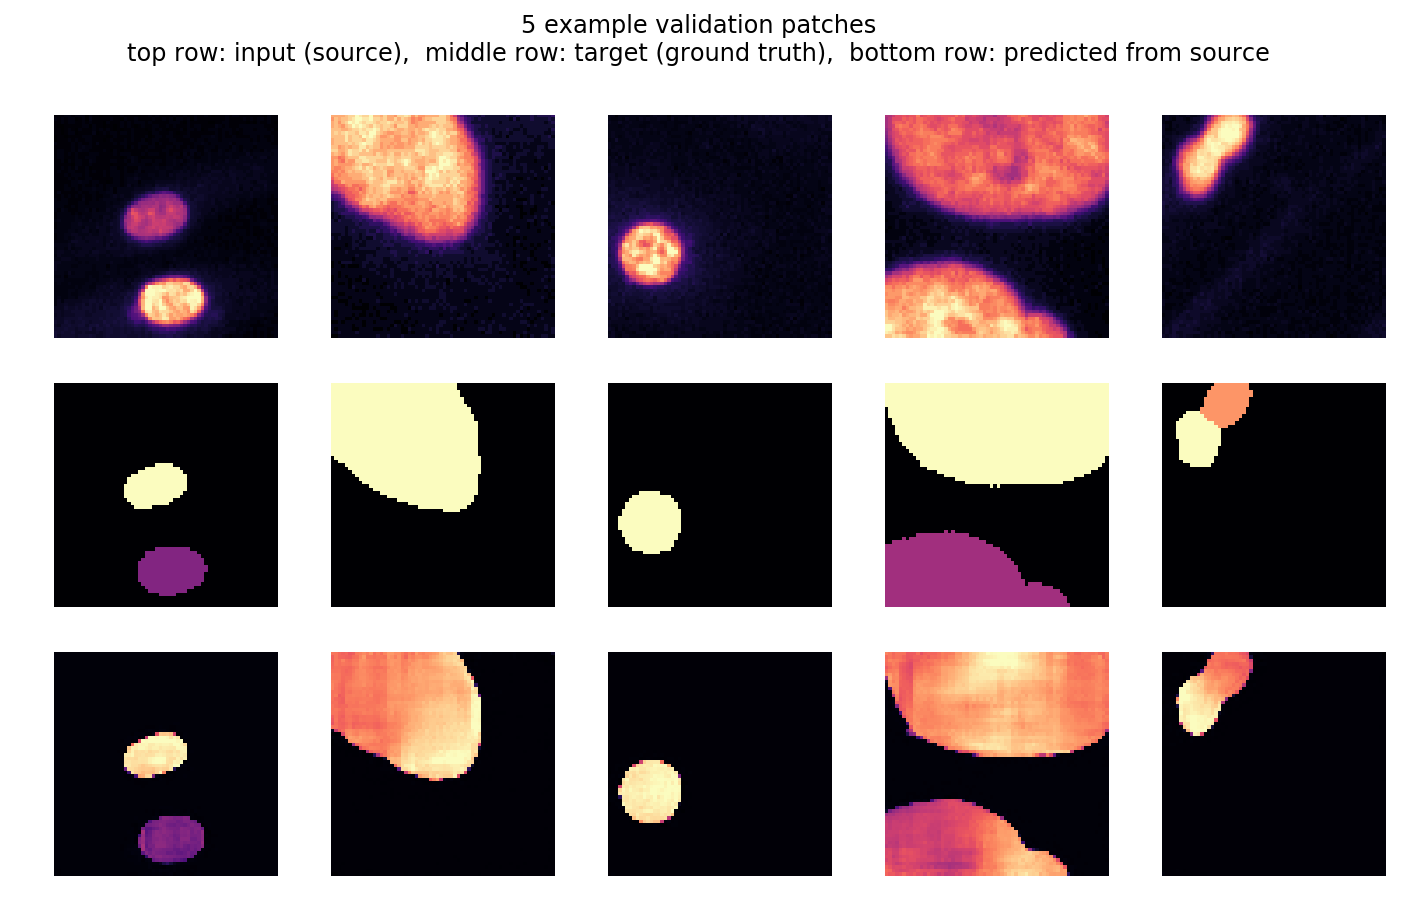

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');
   